## Meeting Date: 11/08/2021
## Meeting Details:
### 1. determine the neighbors points after sampling.  using figure plot to show the points;
### 2. Moving the GCN layer after the five layers.
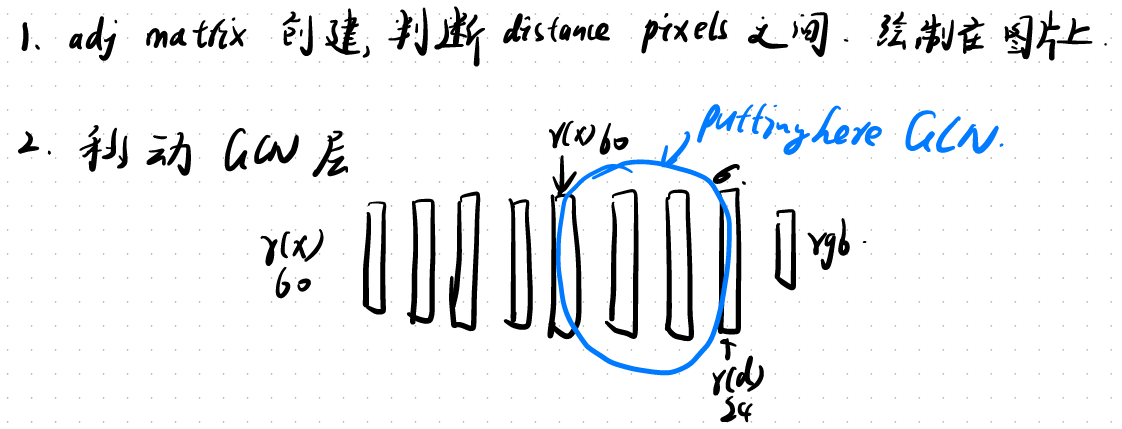

-----
## Before requirement, comparing the reference tensorboard images to our results.
----

## Reference datasets
<table>
<td> 
<img src="rf_train.png" style="width:350;height:350px;"> <br>
</td> 
<td> 
<img src="rf_val.png" style="width:350;height:350px;"> <br>
</td> 
</table>
<caption><center>

## Fixing the point 1:

## Fixing the point 2:

### Solutions: 
1.  Moving the GCN layer into layer Five.

In [ ]:
class NeRF(nn.Module):
    def __init__(self,
                 D=8, W=256,
                 in_channels_xyz=63, in_channels_dir=27,
                 skips=[4]):
        """
        D: number of layers for density (sigma) encoder
        W: number of hidden units in each layer
        in_channels_xyz: number of input channels for xyz (3+3*10*2=63 by default)
        in_channels_dir: number of input channels for direction (3+3*4*2=27 by default)
        skips: add skip connection in the Dth layer
        """
        super(NeRF, self).__init__()
        self.D = D
        self.W = W
        self.in_channels_xyz = in_channels_xyz
        self.in_channels_dir = in_channels_dir
        self.skips = skips

        # xyz encoding layers
        for i in range(D):
            if i == 0:
                layer = nn.Linear(in_channels_xyz, W)
            elif i in skips:
                layer = nn.Linear(W+in_channels_xyz, W)
            else:
                layer = nn.Linear(W, W)
            layer = nn.Sequential(layer, nn.ReLU(True))
            setattr(self, f"xyz_encoding_{i+1}", layer)
        self.xyz_encoding_final = nn.Linear(W, W)

        self.gcn = GraphConvolution(W, W)

        # direction encoding layers
        self.dir_encoding = nn.Sequential(
                                nn.Linear(W+in_channels_dir, W//2),
                                nn.ReLU(True))

        # output layers
        self.sigma = nn.Linear(W, 1)
        self.rgb = nn.Sequential(
                        nn.Linear(W//2, 3),
                        nn.Sigmoid())

    def forward(self, x, adj, sigma_only=False):
        """
        Encodes input (xyz+dir) to rgb+sigma (not ready to render yet).
        For rendering this ray, please see rendering.py

        Inputs:
            x: (B, self.in_channels_xyz(+self.in_channels_dir))
               the embedded vector of position and direction
            adj: (n, n) is the adjacency matrix about the nodes.
            sigma_only: whether to infer sigma only. If True,
                        x is of shape (B, self.in_channels_xyz)

        Outputs:
            if sigma_ony:
                sigma: (B, 1) sigma
            else:
                out: (B, 4), rgb and sigma
        """
        if not sigma_only:
            input_xyz, input_dir = \
                torch.split(x, [self.in_channels_xyz, self.in_channels_dir], dim=-1)
        else:
            input_xyz = x

        xyz_ = input_xyz
        for i in range(self.D):
            
#--------------------------------------------------------#
#       Changing Here
#---------------------------------------------------------#
            if i in [5]:
                xyz_ = F.relu(self.gcn(xyz_, adj))
#--------------------------------------------------------#
#       Changing Here
#---------------------------------------------------------#
            
            if i in self.skips:
                xyz_ = torch.cat([input_xyz, xyz_], -1)
            xyz_ = getattr(self, f"xyz_encoding_{i+1}")(xyz_)

        sigma = self.sigma(xyz_)
        if sigma_only:
            return sigma

        xyz_encoding_final = self.xyz_encoding_final(xyz_)
        ## changes, xyz_encoding : torch.Size([32768, 256])

        dir_encoding_input = torch.cat([xyz_encoding_final, input_dir], -1)
        dir_encoding = self.dir_encoding(dir_encoding_input)
        rgb = self.rgb(dir_encoding)

        out = torch.cat([rgb, sigma], -1)

        return out

### Results:
